In [81]:
#using Pkg
#Pkg.add(url="https://github.com/QEDjl-project/QEDprocesses.jl/")

using MetagraphOptimization
using CUDA
using UUIDs
using BenchmarkTools

println("Threads: $(Threads.nthreads())")

Threads: 32


In [98]:
using Random

# preparation of graph
machine = Machine([MetagraphOptimization.NumaNode(0, 1, MetagraphOptimization.default_strategy(MetagraphOptimization.NumaNode), -1.0, UUIDs.uuid1())], [-1.0;;])
model = QEDModel()
process = parse_process("ke->kkke", model)
graph = gen_graph(process)
n_inputs = 2^20
inputs = [gen_process_input(process) for _ in 1:n_inputs]
cu_inputs = CuArray(inputs)
optimizer = RandomWalkOptimizer(MersenneTwister(0))# GreedyOptimizer(GlobalMetricEstimator())

#done: split, reduce, fuse, greedy

process_str_short = "qed_k3"
optim_str = "Random Walk Optimization"
optim_str_short="random"

get_compute_function(graph, process, machine) # run once for compilation

compute__f86f16c2_dcba_11ee_3d4b_6b88d96bf393 (generic function with 1 method)

In [99]:
function bench(func, kernel!, inputs, cu_inputs)
    compile_time = @elapsed func(inputs[1])

    # b = @benchmark $func.($inputs) samples = 10 evals = 1
    single_thread = 0. # median(b.times) / 1e9
    st_std = 0. # std(b.times) / 1e9

    b = @benchmark begin 
            Threads.@threads for i in eachindex($inputs)
            $func($inputs[i]) 
        end 
    end samples = 10 evals = 1
    multi_threaded = median(b.times) / 1e9
    mt_std = std(b.times) / 1e9
    
    n = length(cu_inputs)
    ts = 32
    bs = Int(n / ts)
    cu_outputs = CuVector{ComplexF64}()
    resize!(cu_outputs, n)
    b = @benchmark begin
        @cuda threads = $ts blocks = $bs always_inline=true $kernel!($cu_inputs, $cu_outputs, $n)
        CUDA.device_synchronize()
    end samples = 10 evals = 1
    gpu_compile = 0
    gpu = median(b.times) / 1e9
    gpu_std = std(b.times) / 1e9

    return (cpu_compile_time = compile_time, gpu_compile_time = gpu_compile, cpu_single_thread_time = single_thread, cpu_st_std = st_std, cpu_multi_thread_time = multi_threaded, cpu_mt_std = mt_std, gpu_time = gpu, gpu_std = gpu_std)
end

bench (generic function with 1 method)

In [100]:
# bench and produce data
using DataFrames

STEPSIZE = 1
n = 0

df = DataFrame(
    operations=Int[], 
    graph_nodes=Int[], 
    graph_edges=Int[], 
    graph_ce=Float64[], 
    graph_dt=Float64[], 
    graph_ci=Float64[], 
    gen_func_t=Float64[], 
    cpu_compile_t=Float64[], 
    cpu_st_t=Float64[], 
    cpu_st_std=Float64[],
    cpu_mt_t=Float64[], 
    cpu_mt_std=Float64[],
    gpu_compile_t=Float64[], 
    gpu_t=Float64[],
    gpu_std=Float64[]
)

while true
    func_gen_time = @elapsed func = get_compute_function(graph, process, machine)
    kernel! = get_cuda_kernel(graph, process, machine)
    res = bench(func, kernel!, inputs, cu_inputs)

    graph_properties = get_properties(graph)
    push!(df, (
        n,
        graph_properties.noNodes,
        graph_properties.noEdges,
        graph_properties.computeEffort,
        graph_properties.data,
        graph_properties.computeIntensity,
        func_gen_time,
        res.cpu_compile_time,
        res.cpu_single_thread_time,
        res.cpu_st_std,
        res.cpu_multi_thread_time,
        res.cpu_mt_std,
        res.gpu_compile_time,
        res.gpu_time,
        res.gpu_std
    ))

    print("I")

    if fixpoint_reached(optimizer, graph)
        break
    end

    if n >= 100
        break
    end

    optimize!(optimizer, graph, STEPSIZE)
    n += STEPSIZE
end
println("\nDone")
;

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
Done


In [101]:
using LaTeXStrings

function beautify_title(str::AbstractString)
    parts = split(str, "'")

    preprefix = parts[1]
    infix = parts[2]
    sufsuffix = parts[3]

    parts = split(infix, "->")

    prefix = parts[1]
    suffix = parts[2]

    k_count = count(c -> c == 'k', suffix)
    B_count = count(c -> c == 'B', suffix)

    if k_count == 1 || B_count == 1
        new_suffix = suffix
    elseif k_count >= 1
        new_suffix = replace(suffix, r"k+" => "k^$k_count")
    elseif B_count >= 1
        new_suffix = replace(suffix, r"B+" => "B^$B_count")
    end

    return preprefix * L"%$prefix \rightarrow %$new_suffix" * sufsuffix
end

beautify_title (generic function with 1 method)

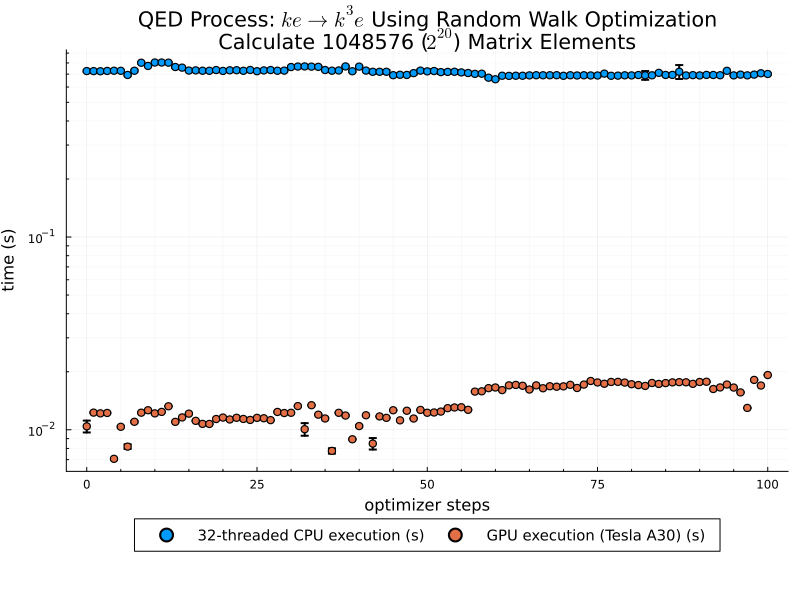

In [102]:
# plot data
using Plots
using StatsPlots

img = @df df scatter(
    :operations, 
    [#=:cpu_st_t=# :cpu_mt_t :gpu_t],
    label=[#="Single threaded execution (s)"=# "$(Threads.nthreads())-threaded CPU execution (s)" "GPU execution (Tesla A30) (s)"],
    yerror=[#=:cpu_st_std=# :cpu_mt_std :gpu_std],
    title="$(beautify_title(string(process))) Using $(optim_str)\nCalculate $(n_inputs) (\$2^{20}\$) Matrix Elements",
    linewidth=2,
    xlabel="optimizer steps",
    ylabel="time (s)",
    yscale=:log10,
    legend=:outerbottom,
    legendcolumns=2,
    legend_font_pointsize=10,
    minorgrid=true,
    size=(800, 600),
    fmt=:pdf
)

savefig(img, "../images/$(process_str_short)_execution_$(optim_str_short).pdf")

img

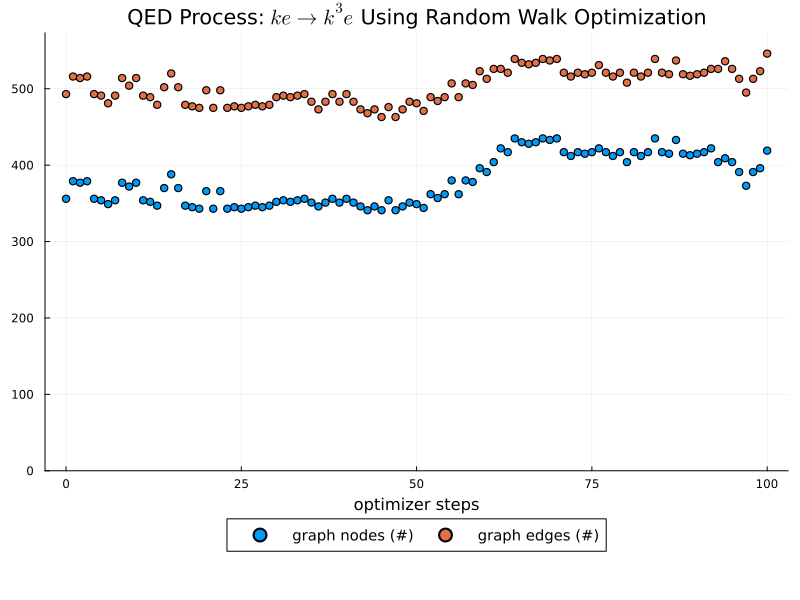

In [103]:
img = @df df scatter(
    :operations,
    [:graph_nodes, :graph_edges],
    label=["graph nodes (#)" "graph edges (#)"],
    title="$(beautify_title(string(process))) Using $(optim_str)",
    linewidth=2,
    xlabel="optimizer steps",
    ylims=(0.0, 1.05 * maximum(df.graph_edges)),
    legend=:outerbottom,
    legendcolumns=2,
    legend_font_pointsize=10,
    fmt=:pdf,
    size=(800, 600)
)

savefig(img, "../images/$(process_str_short)_nodes_edges_$(optim_str_short).pdf")

img

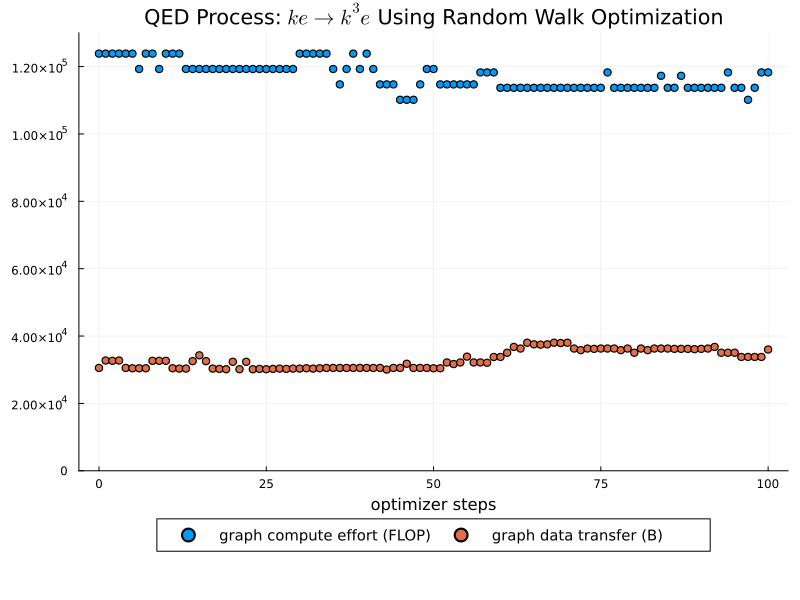

In [104]:
img = @df df scatter(
    :operations,
    [:graph_ce, :graph_dt],
    label=["graph compute effort (FLOP)" "graph data transfer (B)"],
    title="$(beautify_title(string(process))) Using $(optim_str)",
    linewidth=2,
    xlabel="optimizer steps",
    ylims=(0.0, 1.05 * maximum(df.graph_ce)),
    legend=:outerbottom,
    legendcolumns=2,
    legend_font_pointsize=10,
    fmt=:pdf,
    size=(800, 600)
)

savefig(img, "../images/$(process_str_short)_ce_dt_$(optim_str_short).pdf")

img

┌ Warning: n° of legend_column=2 is larger than n° of series=1
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends/gr.jl:1235


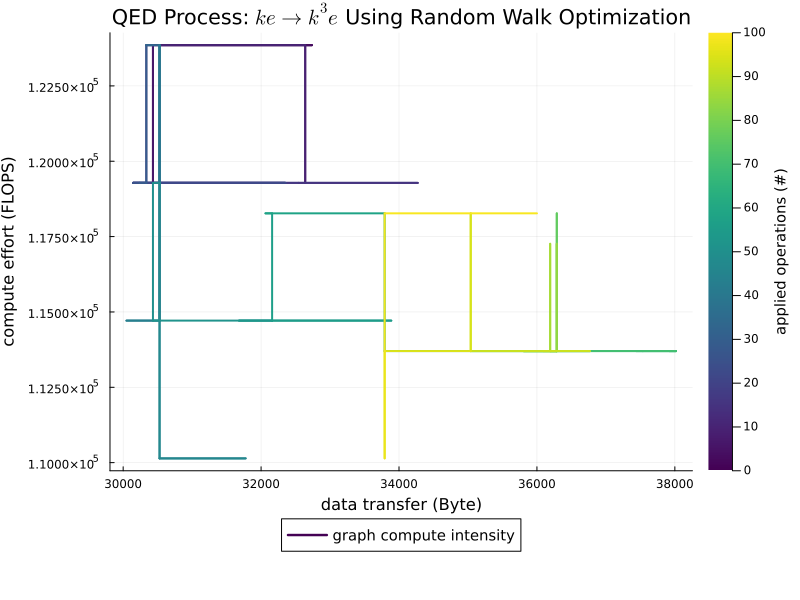

┌ Warning: n° of legend_column=2 is larger than n° of series=1
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends/gr.jl:1235
┌ Warning: n° of legend_column=2 is larger than n° of series=1
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends/gr.jl:1235


In [106]:
img = @df df plot(
    :graph_dt,
    :graph_ce,
    label="graph compute intensity",
    title="$(beautify_title(string(process))) Using $(optim_str)",
    line_z=:operations,
    color=:viridis,
    linewidth=2,
    xlabel="data transfer (Byte)",
    ylabel="compute effort (FLOPS)",
    colorbar_title="applied operations (#)",
    colorbar_ticks=(0, maximum(df.operations)),
    #ylims=(0.0, 1.05 * maximum(df.graph_ce)),
    #xlims=(0.0, 1.05 * maximum(df.graph_dt)),
    legend=:outerbottom,
    legendcolumns=2,
    legend_font_pointsize=10,
    fmt=:pdf,
    size=(800, 600)
)

savefig(img, "../images/$(process_str_short)_cdplot_$(optim_str_short).pdf")

img